## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import Sequential, ReLU, Module, Dropout, Sigmoid, Linear, BatchNorm2d
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from cv2 import PSNR
from SSIM_PIL import compare_ssim
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

## Load data

In [4]:
seed = 42   # for reproducibility
torch.manual_seed(seed)     # set seed for torch
torch.backends.cudnn.benchmark = False 
torch.backends.cudnn.deterministic = True 
batch_size = 512
epochs = 40 
learning_rate = 1e-4

### Creating train, val & test loaders

In [5]:
svhn = datasets.SVHN(root='E:/torchvision/datasets', download=False, transform=transforms.ToTensor())
# downloaded the SVHN dataset

# using train_test_split to split the dataset into train, test and validation sets

train_data, test_data = train_test_split(svhn, train_size=0.8, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=42)

# creating dataloaders for train, test and validation sets
# Dataloaders will create batches of data with the specified batch size and shuffle them to induce randomness to avoid overfitting

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
# Checking the shape of the input 

print("Train data")
print(len(train_data))   # length of the train data
for batch in train_loader:
    images, labels = batch
    print(images.shape)     # shape of the images
    print(labels.shape)     # shape of the labels
    break

print("\nValidation data")
print(len(val_data))
for batch in val_loader:
    images, labels = batch
    print(images.shape)
    print(labels.shape)
    break

print("\nTest data")
print(len(test_data))
for batch in test_loader:
    images, labels = batch
    print(images.shape)
    print(labels.shape)
    break

Train data
51279
torch.Size([512, 3, 32, 32])
torch.Size([512])

Validation data
7326
torch.Size([512, 3, 32, 32])
torch.Size([512])

Test data
14652
torch.Size([512, 3, 32, 32])
torch.Size([512])


## Undercomplete model architecture

In [7]:
class UnderCompleteAutoencoder(nn.Module):
    def __init__(self,input_dim):
        super(UnderCompleteAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(input_dim*0.75)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.75), int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), int(input_dim*0.25)),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(int(input_dim*0.25), int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), int(input_dim*0.75)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.75), input_dim),
            nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# defining the model, optimizer and loss function

# we shall select the device to be cuda (gpu) if available else cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   

# We initialise the model by creating an object of the class defined above
model = UnderCompleteAutoencoder(input_dim=3*32*32).to(device)

# We define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Here we define the loss function
criterion = nn.MSELoss()

## Without noise

### Training undercomplete model

In [ ]:
# In this section, we shall use the original images as input and pass them through the model to get the reconstructed images
# We shall then compare the original images with the reconstructed images using PSNR and SSIM scores.

In [8]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    running_loss = 0
    for images, _ in train_loader:

        images = images.reshape(-1, 3072).to(device)        # reshaping the images to 3072 dimensions - flattening
        optimizer.zero_grad()                               # setting the gradients to zero
        outputs = model(images)                             # passing the images through the model
        train_loss = criterion(outputs, images)             # calculating the loss
        train_loss.backward()                               # backpropagating the loss to compute the gradients
        optimizer.step()                                    # updating the weights
        running_loss += train_loss.item()                   

    training_loss = running_loss/len(train_loader)

    with torch.no_grad():                                   # we do not need to calculate the gradients for validation
        val_running_loss = 0
        for images, _ in val_loader:
            images = images.reshape(-1, 3072).to(device)
            outputs = model(images)
            val_loss = criterion(outputs, images)
            val_running_loss += val_loss.item()
    
    validation_loss = val_running_loss/len(val_loader)

    train_losses.append(training_loss)
    val_losses.append(validation_loss)

    print("Epoch : ",epoch+1,"/",epochs,"Training loss = ",round(training_loss,6), "Validation loss = ",round(validation_loss,6))

Epoch :  1 / 40 Training loss =  0.028543 Validation loss =  0.019423
Epoch :  2 / 40 Training loss =  0.01616 Validation loss =  0.015841
Epoch :  3 / 40 Training loss =  0.01438 Validation loss =  0.013424
Epoch :  4 / 40 Training loss =  0.012481 Validation loss =  0.012643
Epoch :  5 / 40 Training loss =  0.011769 Validation loss =  0.010826
Epoch :  6 / 40 Training loss =  0.010341 Validation loss =  0.010057
Epoch :  7 / 40 Training loss =  0.010014 Validation loss =  0.010029
Epoch :  8 / 40 Training loss =  0.009867 Validation loss =  0.009936
Epoch :  9 / 40 Training loss =  0.00985 Validation loss =  0.009925
Epoch :  10 / 40 Training loss =  0.009694 Validation loss =  0.009393
Epoch :  11 / 40 Training loss =  0.009297 Validation loss =  0.009153
Epoch :  12 / 40 Training loss =  0.008634 Validation loss =  0.00857
Epoch :  13 / 40 Training loss =  0.008361 Validation loss =  0.008147
Epoch :  14 / 40 Training loss =  0.007979 Validation loss =  0.008287
Epoch :  15 / 40 Tr

In [9]:
# We shall save the best model based on the validation loss for testing in future.
import pickle
pickle.dump(model, open("undercomplete_autoencoder.pkl", "wb"))

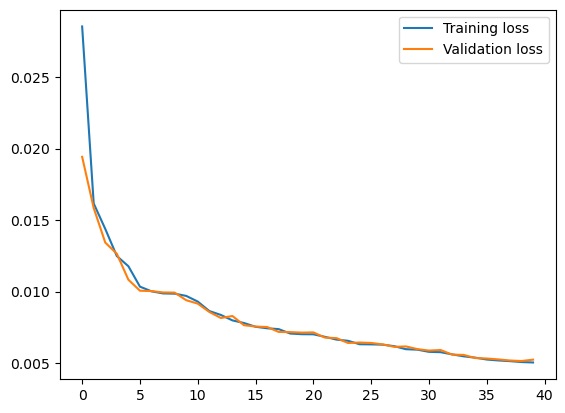

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

### Testing of undercomplete model

In [ ]:
# In testing, we shall use the best model saved above and pass the test images through it to get the reconstructed images.
# We shall then compare the original images with the reconstructed images using PSNR and SSIM scores.

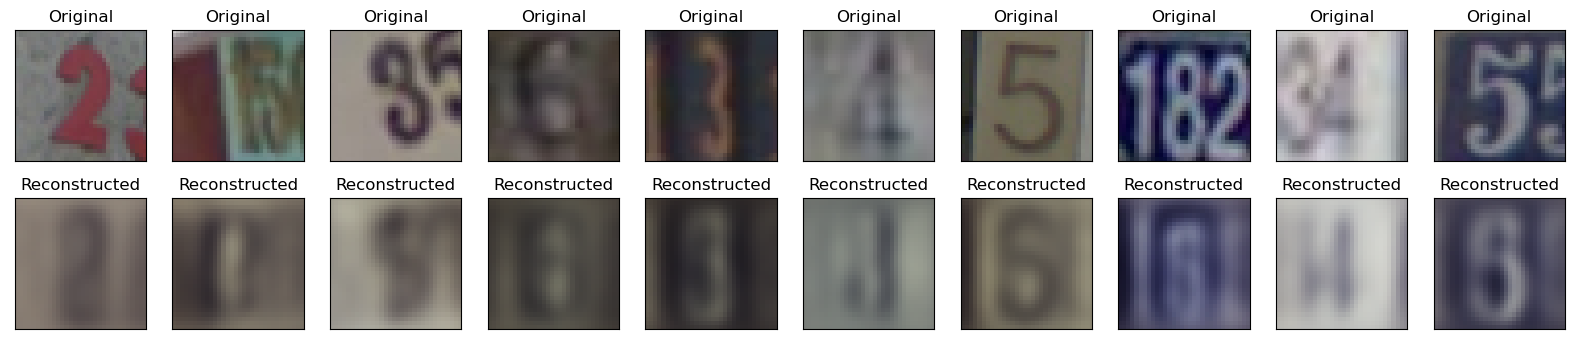

In [11]:
test_examples = None
with torch.no_grad():                                               # we do not need to calculate the gradients for testing
    for batch_features in test_loader:                              # iterating through the test data
        batch_features = batch_features[0].to(device)               # batch_features are the images in tensor form
        test_examples = batch_features.view(-1,3072)                # reshaping the images to 3072 dimensions - flattening
        reconstruction = model(test_examples).view(-1,3,32,32)      # passing the images through the model
        test_examples = test_examples.view(-1,3,32,32)              # reshaping the images to 3x32x32 dimensions
        

with torch.no_grad():       
    number = 10
    plt.figure(figsize=(20, 4))

    for index in range(number):
        
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].permute(1,2,0).cpu().numpy(), cmap='gray')
        plt.gray()
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].permute(1,2,0).cpu().numpy(), cmap='gray')
        plt.gray()
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

### Reconstruction accuracy

In [ ]:
# We shall now calculate the PSNR and SSIM scores for the reconstructed images

'''PSNR'''
# PSNR stands for Peak Signal to Noise Ratio. It is a metric to measure the quality of reconstructed images.
# Higher the PSNR, better the quality of the reconstructed image.
''' PSNR = 20 * log10(MAXp) - 10 * log10(MSE) '''
# where MAXp = maximum possible pixel value of the image
# MSE = mean squared error between the original and reconstructed images

'''SSIM'''
# SSIM stands for Structural Similarity Index. It is a metric to measure the similarity between the original and reconstructed images.
# Higher the SSIM, better the quality of the reconstructed image.
''' SSIM = (2*mean_x*mean_y + c1)*(2*cov_xy + c2) / (mean_x^2 + mean_y^2 + c1)*(var_x + var_y + c2) '''
# where mean_x = mean of the original image, 
# mean_y = mean of the reconstructed image
# cov_xy = covariance of the original and reconstructed images, 
# var_x = variance of the original image 
# var_y = variance of the reconstructed image.

In [12]:
PSNR_values = []

for i in range(len(test_examples)):
    PSNR_values.append(PSNR(test_examples[i].permute(1,2,0).cpu().numpy(), reconstruction[i].permute(1,2,0).cpu().numpy()))

print("Average PSNR value (reconstruction accuracy) = ",np.mean(PSNR_values))

Average PSNR value (reconstruction accuracy) =  72.40515116171142


In [20]:
SSIM_values = []

for i in range(len(test_examples)):

    img = test_examples[i].permute(1,2,0).cpu().numpy()
    reconstructed = reconstruction[i].permute(1,2,0).cpu().numpy()

    original = Image.fromarray((img*255).astype(np.uint8))
    reconstructed = Image.fromarray((reconstructed * 255).astype(np.uint8))

    ssim_val = compare_ssim(original, reconstructed)
    SSIM_values.append(ssim_val)

print("Average SSIM value (reconstruction accuracy) = ",np.mean(SSIM_values))

Average SSIM value (reconstruction accuracy) =  0.7501918689813465


## With Noise Introduced

In [21]:
# In this section, we shall first induce the original images with random Gaussian noise.
# Then we shall use the noisy images as input and pass them through the model to get the encoded images.
# We shall then decode the encoded images to get the reconstructed images.

# It is expected that the encoding and decoding task, removes the noise from the images and reconstructs the original images.

### Training 

In [23]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    running_loss = 0
    for images, _ in train_loader:

        images = images.reshape(-1, 3072).to(device)
        shape = images.shape

        error = 0.02*torch.randn(shape).to(device)              # gaussian noise
        images = images + error                                 # adding the noise to the images

        optimizer.zero_grad()
        outputs = model(images)
        train_loss = criterion(outputs, images)
        train_loss.backward()
        optimizer.step()
        running_loss += train_loss.item()

    training_loss = running_loss/len(train_loader)

    with torch.no_grad():
        val_running_loss = 0
        for images, _ in val_loader:

            images = images.reshape(-1, 3072).to(device)
            shape = images.shape

            error = 0.02*torch.randn(shape).to(device)          # gaussian noise
            images = images + error                             # adding the noise to the images of validation set

            outputs = model(images)
            val_loss = criterion(outputs, images)
            val_running_loss += val_loss.item()
    
    validation_loss = val_running_loss/len(val_loader)

    train_losses.append(training_loss)
    val_losses.append(validation_loss)

    print("Epoch : ",epoch+1,"/",epochs,"Training loss = ",round(training_loss,6), "Validation loss = ",round(validation_loss,6))

Epoch :  1 / 40 Training loss =  0.003556 Validation loss =  0.003606
Epoch :  2 / 40 Training loss =  0.003531 Validation loss =  0.003609
Epoch :  3 / 40 Training loss =  0.003481 Validation loss =  0.004221
Epoch :  4 / 40 Training loss =  0.003483 Validation loss =  0.003496
Epoch :  5 / 40 Training loss =  0.003433 Validation loss =  0.003502
Epoch :  6 / 40 Training loss =  0.00343 Validation loss =  0.003486
Epoch :  7 / 40 Training loss =  0.003331 Validation loss =  0.003902
Epoch :  8 / 40 Training loss =  0.003348 Validation loss =  0.003482
Epoch :  9 / 40 Training loss =  0.00329 Validation loss =  0.003697
Epoch :  10 / 40 Training loss =  0.003288 Validation loss =  0.003381
Epoch :  11 / 40 Training loss =  0.003215 Validation loss =  0.003283
Epoch :  12 / 40 Training loss =  0.003233 Validation loss =  0.00326
Epoch :  13 / 40 Training loss =  0.003199 Validation loss =  0.003257
Epoch :  14 / 40 Training loss =  0.003182 Validation loss =  0.003404
Epoch :  15 / 40 T

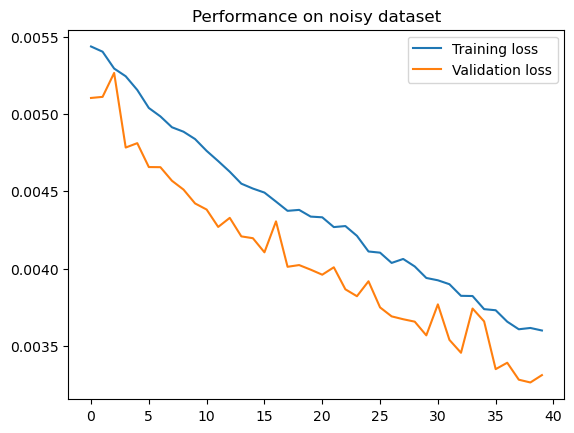

In [14]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Performance on noisy dataset')
plt.legend()
plt.show()

### Testing

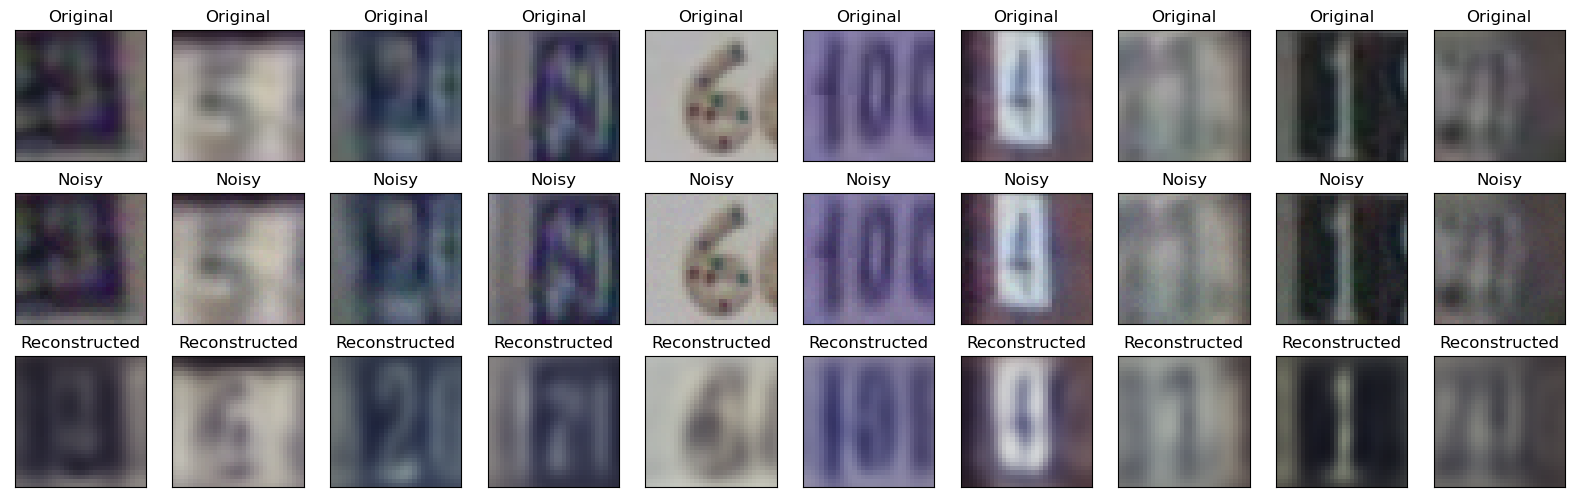

In [15]:
test_examples = None
original_examples = None

with torch.no_grad():
    for batch_features,_ in test_loader:

        shape = batch_features.shape
        error = 0.01*torch.randn(shape).to(device)

        original_examples = batch_features.to(device)
        batch_features = original_examples + error

        original_examples = original_examples.view(-1,3,32,32)
        test_examples = batch_features.view(-1,3072)
        
        reconstruction = model(test_examples).view(-1,3,32,32)
        test_examples = test_examples.view(-1,3,32,32)
        break

with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 6))

    for index in range(number):
        
        # display original
        ax = plt.subplot(3, number, index + 1)
        plt.imshow(original_examples[index].permute(1,2,0).cpu().numpy(), cmap='gray')
        plt.gray()
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy
        ax = plt.subplot(3, number, index + 1 + number)
        plt.imshow(batch_features[index].permute(1,2,0).cpu().numpy(), cmap='gray')
        plt.gray()
        plt.title("Noisy")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + 1 + 2*number)
        plt.imshow(reconstruction[index].permute(1,2,0).cpu().numpy(), cmap='gray')
        plt.gray()
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

### Reconstruction accuracy

In [24]:
# We shall now calculate the PSNR and SSIM scores for the reconstructed images that are obtained from the noisy images
# We shall compare the PSNR and SSIM scores with the scores obtained for the reconstructed images from the original images

In [16]:
PSNR_values = []

for i in range(len(test_examples)):
    PSNR_values.append(PSNR(test_examples[i].permute(1,2,0).cpu().numpy(), reconstruction[i].permute(1,2,0).cpu().numpy()))

print("Average PSNR value (reconstruction accuracy) = ",np.mean(PSNR_values))

Average PSNR value (reconstruction accuracy) =  74.28287933580702


In [17]:
SSIM_values = []

for i in range(len(test_examples)):

    img = test_examples[i].permute(1,2,0).cpu().numpy()
    reconstructed = reconstruction[i].permute(1,2,0).cpu().numpy()

    original = Image.fromarray((img*255).astype(np.uint8))
    reconstructed = Image.fromarray((reconstructed * 255).astype(np.uint8))

    ssim_val = compare_ssim(original, reconstructed)
    SSIM_values.append(ssim_val)

print("Average SSIM value (reconstruction accuracy) = ",np.mean(SSIM_values))

Average SSIM value (reconstruction accuracy) =  0.7501918689813465


## 